# Effects of Bad Family Relations on Student Academics
### Introduction

Our topic based on the dataset we chose is to find a relationship between a student’s academics and the relations within their family. 

Question: Does bad relations within students’ families affect their studies?

The data set we chose is the Student Performance Data Set, which displays student achievement in secondary education of two Portuguese schools. The data contains every kind of information of the student. It ranges from the students’ age to their alcohol consumption, to information about their parents.

### Preliminary exploratory data analysis
#### Libraries

In [53]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### Reading the data set

In [3]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
student_data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)
student_data

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


#### Cleaning the data

In [71]:
student_tidy_data <- student_data %>%
    select(c(studytime, failures, famsup, higher, famrel, absences, G3)) %>%
    mutate_at(c("studytime", "failures", "famsup", "higher"), as.factor) %>%
    mutate_if(is.numeric, function(x) (x - mean(x)) / sd(x)) %>%
    group_by(famsup, famrel) %>%
    count(failures) %>%
    mutate(max = max(n)) %>%
    subset(n = max(n)) %>%
    mutate(Keep = case_when(
        n > 1 ~ TRUE,
        n == 1 & failures == head(failures, 1) ~ TRUE,
        TRUE ~ FALSE)) %>%
    subset(Keep) %>%
    select(famsup, famrel, failures)
student_tidy_data

famsup,famrel,failures
<fct>,<dbl>,<fct>
no,-3.283640,0
no,-2.168388,0
no,-1.053136,0
⋮,⋮,⋮
yes,1.177367,1
yes,1.177367,2
yes,1.177367,3


#### Data summary

In [76]:
student_split <- initial_split(student_tidy_data, prop = 0.75)
student_train <- training(student_split)
student_test <- testing(student_split)
summary(student_train)

 famsup       famrel         failures
 no : 8   Min.   :-3.28364   0:7     
 yes:13   1st Qu.:-1.05314   1:5     
          Median : 0.06211   2:5     
          Mean   :-0.30963   3:4     
          3rd Qu.: 1.17737           
          Max.   : 1.17737           

#### Data plot

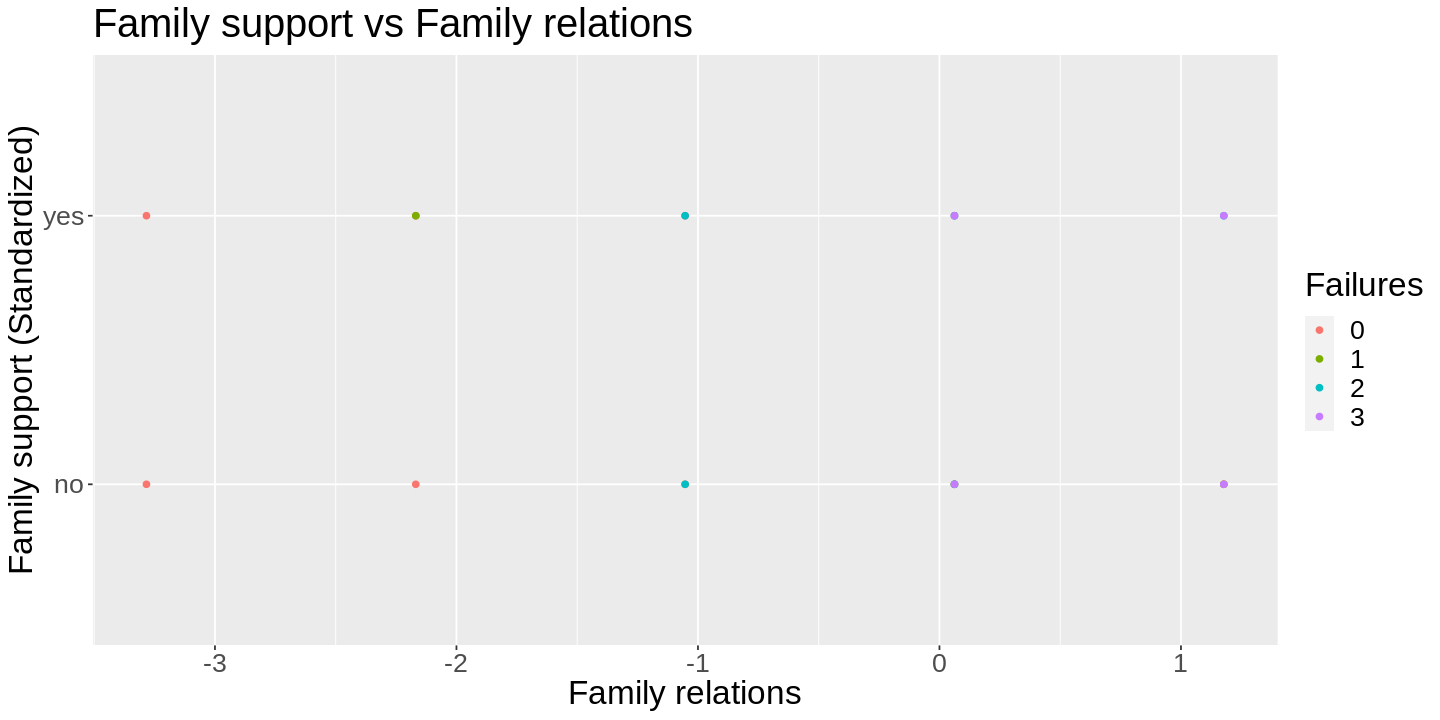

In [74]:
options(repr.plot.width = 12, repr.plot.height = 6)
regression_plot <- student_train %>%
    ggplot(aes(x = famrel, y = famsup, colour = failures)) +
        geom_point() +
        labs(title = "Family support vs Family relations", 
             x = "Family relations", 
             y = "Family support (Standardized)", 
             colour = "Failures") +
        theme(text = element_text(size = 20))
regression_plot

### Methods

For this data analysis, we chose to only look at the final grade (G3). We will conduct this process using the variables/columns; failures, higher, famrel, and famsup. We chose these variables because it is the relationships within the families that we are observing, therefore famsup is used. The number of class failures is also looked at as we relate those with the other variables. Lastly, we would also like to take into account how many students want to take higher education as bad relations within the family could influence these results.
A scatterplot would be used to visualize the results because they detect whether a relationship or correlation between two variables exist, which is what we are trying to visualize with our data. We will be performing a classification, therefore a scatterplot would display this data the best.

### Expected outcomes and significance

#### What do you expect to find?
We think this model will give a more clear insight to how bad relations can affect students' education by classifying  attributes like final grade, and even how likely it is that they will fail. We expect that students with such conditions are more likely to opt to pursue higher education but are also more likely to fail.

#### What impact could such findings have?
We think such insight will help schools as well as parents be more prepared in helping the students succeed and get a better education; by providing students extra classes, ways to open up and deal with the mental issues and even give them more opportunities in their interest fields to divert their minds from the issues at their homes.

#### What future questions could this lead to?
From this data analysis, we would find out how relationships within the student’s families affect their studies, but what about other factors within a students’ life? Questions such as;
How does students’ health relate to their academic education?
Could a  student’s romantic relationship affect their studies?
How does a student’s use of their freetime contribute to their studies?
